In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import shutil 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as FT
from torchvision.transforms.v2 import functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchinfo import summary
import copy
import datetime
import random
import traceback
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
seed = 42
import cv2
import xml.etree.ElementTree as ET
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from collections import Counter

In [2]:
from torchvision import models
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.avgpool = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
#resnet18_model.avgpool = nn.Sequential()
resnet50_model.fc = nn.Sequential()
for param in resnet50_model.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [3]:
summary(resnet50_model, input_size=(16, 3, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 100352]              --
├─Conv2d: 1-1                            [16, 64, 224, 224]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 224, 224]        128
├─ReLU: 1-3                              [16, 64, 224, 224]        --
├─MaxPool2d: 1-4                         [16, 64, 112, 112]        --
├─Sequential: 1-5                        [16, 256, 112, 112]       --
│    └─Bottleneck: 2-1                   [16, 256, 112, 112]       --
│    │    └─Conv2d: 3-1                  [16, 64, 112, 112]        4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 112, 112]        128
│    │    └─ReLU: 3-3                    [16, 64, 112, 112]        --
│    │    └─Conv2d: 3-4                  [16, 64, 112, 112]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 112, 112]        128
│    │    └─ReLU: 3-6                    [16, 64, 112, 112]        --
│ 

In [4]:
files_dir = '/kaggle/input/bts-members-detection/images'

In [6]:
temp1 = ['/'+image for image in sorted(os.listdir(files_dir))
                        if (image[-4:]=='.png') and (image[:-4]+'.txt' in os.listdir(files_dir))
         and os.path.getsize(files_dir+'/'+image[:-4]+'.txt') != 0]
temp2 = ['/'+annot for annot in sorted(os.listdir(files_dir))
                        if (annot[-4:]=='.txt') and os.path.getsize(files_dir+'/'+annot) != 0]

images = pd.Series(temp1, name='images')
image_id = pd.Series(list(range(len(temp1))), name='id')
train_img_df = pd.DataFrame(pd.concat([images, image_id], axis=1))
images = []
image_id = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for j in range(len(file.readlines())):
            images.append(temp1[i])
            image_id.append(i)
        file.close()
bboxes = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for line in file.readlines():
            bboxes.append(list(map(float, line.split())))
        file.close()
images = pd.Series(images, name='images')
bboxes = pd.Series(bboxes, name='bboxes')
image_id = pd.Series(image_id, name='image_id')
ind = pd.Series(list(range(len(images))), name='id')
df = pd.concat([images, ind,image_id,bboxes], axis=1)
train_df = pd.DataFrame(df)
area = []
for i in range(train_df.shape[0]):
    img_path = files_dir + train_df.iloc[i,0]
    img = read_image(img_path)
    area.append(train_df.iloc[i,3][3]*train_df.iloc[i,3][4])
train_df = pd.concat([train_df, pd.Series(area, name='area')],axis=1)

In [7]:
train_df

,images,id,image_id,bboxes,area
0,/jhope0.png,0,0,"[0.0, 0.497253, 0.289855, 0.467033, 0.543478]",0.253822
1,/jhope1.png,1,1,"[0.0, 0.477778, 0.391111, 0.848889, 0.782222]",0.664020
2,/jhope10.png,2,2,"[0.0, 0.4, 0.393333, 0.408889, 0.44]",0.179911
3,/jhope100.png,3,3,"[0.0, 0.555184, 0.446429, 0.622074, 0.892857]",0.555423
4,/jhope101.png,4,4,"[0.0, 0.52901, 0.319767, 0.361775, 0.639535]",0.231368
...,...,...,...,...,...
804,/v291.png,804,803,"[5.0, 0.553763, 0.279006, 0.218638, 0.292818]",0.064021
805,/v292.png,805,804,"[5.0, 0.426667, 0.255556, 0.382222, 0.342222]",0.130805
806,/v293.png,806,805,"[5.0, 0.591667, 0.494048, 0.456667, 0.714286]",0.326191
807,/v294.png,807,806,"[5.0, 0.528796, 0.301136, 0.743455, 0.42803]",0.318221


In [9]:
names = sorted(['jhope', 'jimin', 'jin', 'suga', 'jungkook', 'rm', 'v'])
class_names = dict((i, names[i]) for i in range(7))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train, test = train_test_split(train_df, test_size = 0.2, shuffle = True)

In [15]:
np.unique(test.iloc[:,0])

array(['/jhope10.png', '/jhope107.png', '/jhope113.png', '/jhope176.png',
       '/jhope184.png', '/jhope187.png', '/jhope188.png', '/jhope19.png',
       '/jhope198.png', '/jhope211.png', '/jhope22.png', '/jhope279.png',
       '/jhope280.png', '/jhope281.png', '/jhope283.png', '/jhope290.png',
       '/jhope297.png', '/jhope298.png', '/jhope3.png', '/jhope32.png',
       '/jhope37.png', '/jhope4.png', '/jhope5.png', '/jhope50.png',
       '/jhope54.png', '/jhope62.png', '/jhope63.png', '/jhope75.png',
       '/jhope78.png', '/jimin0.png', '/jimin10.png', '/jimin12.png',
       '/jimin177.png', '/jimin183.png', '/jimin208.png', '/jimin214.png',
       '/jimin215.png', '/jimin23.png', '/jimin27.png', '/jimin270.png',
       '/jimin271.png', '/jimin273.png', '/jimin274.png', '/jimin275.png',
       '/jimin277.png', '/jimin297.png', '/jimin304.png', '/jimin310.png',
       '/jimin316.png', '/jimin33.png', '/jimin36.png', '/jimin378.png',
       '/jimin382.png', '/jimin389.png', '/jimin39

In [16]:
img_transforms  = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0932, -0.0971, -0.1260], std=[0.5091, 0.4912, 0.4931])
])

In [17]:
!mkdir train test

In [18]:
!mkdir train/jhope train/jin train/jimin train/jungkook train/suga train/rm train/v

In [19]:
!mkdir test/jhope test/jin test/jimin test/jungkook test/suga test/rm test/v

In [20]:
for class_name in class_names:
    for i in range(train.shape[0]):
        temp = train.iloc[i,0].split('.')[0][1:]
        flags = list(map(str.isalpha, list(temp)))
        temp_str = temp[:flags.index(False)]
        if temp_str == class_names.get(class_name):
            shutil.copy(files_dir+train.iloc[i,0], \
                        '/kaggle/working/train'+'/'+class_names.get(class_name)+train.iloc[i,0])

In [21]:
!ls train/v

v0.png	  v11.png   v15.png   v179.png	v196.png  v208.png  v27.png   v286.png
v10.png   v110.png  v16.png   v18.png	v197.png  v209.png  v270.png  v287.png
v101.png  v112.png  v169.png  v180.png	v198.png  v21.png   v272.png  v288.png
v102.png  v113.png  v170.png  v183.png	v199.png  v212.png  v273.png  v289.png
v103.png  v114.png  v172.png  v185.png	v2.png	  v213.png  v274.png  v293.png
v104.png  v117.png  v173.png  v187.png	v20.png   v218.png  v275.png  v294.png
v105.png  v118.png  v174.png  v19.png	v200.png  v22.png   v278.png  v295.png
v106.png  v119.png  v175.png  v192.png	v201.png  v23.png   v280.png
v107.png  v12.png   v176.png  v193.png	v204.png  v25.png   v281.png
v109.png  v14.png   v177.png  v194.png	v206.png  v26.png   v283.png


In [22]:
for class_name in class_names:
    for i in range(test.shape[0]):
        temp = test.iloc[i,0].split('.')[0][1:]
        flags = list(map(str.isalpha, list(temp)))
        temp_str = temp[:flags.index(False)]
        if temp_str == class_names.get(class_name):
            shutil.copy(files_dir+test.iloc[i,0], \
                        '/kaggle/working/test'+'/'+class_names.get(class_name)+test.iloc[i,0])

In [23]:
!ls test/suga

suga112.png  suga181.png  suga25.png  suga276.png  suga316.png	suga381.png
suga119.png  suga20.png   suga26.png  suga277.png  suga371.png
suga14.png   suga211.png  suga27.png  suga309.png  suga378.png


In [28]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=16,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0,
                    step_size=10,
                    plot=False):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer, step_size)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

# Dynamic plot
    if plot:
        plot_epoch_data = []
        plot_train_loss = []
        plot_val_loss = []

        fig, ax = plt.subplots()
        line_train, = ax.plot([], [], 'r-')
        line_val, = ax.plot([], [], 'b-')
        ax.legend(['train', 'val'])
        ax.set_xlim(0, epoch_n)

        def add_point(epoch_i, train_loss, val_loss):
            max_loss = max(ax.viewLim.y1 / 1.1, train_loss, val_loss)
            ax.set_ylim(0, max_loss * 1.1)
            
            plot_epoch_data.append(epoch_i)
            plot_train_loss.append(train_loss)
            plot_val_loss.append(val_loss)
            line_train.set_data(plot_epoch_data, plot_train_loss)
            line_val.set_data(plot_epoch_data, plot_val_loss)
            clear_output(wait=True)
            display(fig)


    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            

            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n

            if plot:
                add_point(epoch_i, mean_train_loss, mean_val_loss)
            else:
                pass
            
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель! На эпохе {}'.format(epoch_i))
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
        finally:
            if plot:
                plt.close(fig)

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
train_data = ImageFolder(root='/kaggle/working/train', transform=img_transforms)
validation_data = ImageFolder(root='/kaggle/working/test', transform=img_transforms)
train_dataloader = DataLoader(dataset=train_data, batch_size=10, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(dataset=validation_data, batch_size=4, shuffle=False, num_workers=2)

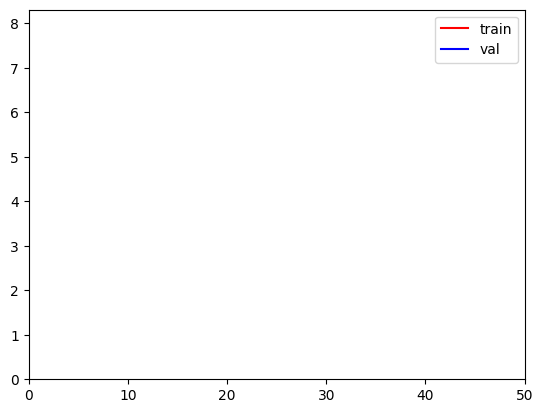

Среднее значение функции потерь на валидации 7.302190115957549
Новая лучшая модель! На эпохе 0

Эпоха 1


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Эпоха: 130 итераций, 39.85 сек
Среднее значение функции потерь на обучении 6.23033841573275


In [ ]:
best_loss, best_model = train_eval_loop(model=resnet50_model, 
                train_dataset=train_data, 
                val_dataset=validation_data, 
                criterion=nn.CrossEntropyLoss(),
                lr=1e-3, 
                epoch_n=50, 
                batch_size=5,
                device=device, 
                early_stopping_patience=5, 
                l2_reg_alpha=0,
                max_batches_per_epoch_train=10000,
                max_batches_per_epoch_val=1000,
                data_loader_ctor=DataLoader,
                optimizer_ctor=torch.optim.Adam,
                lr_scheduler_ctor=torch.optim.lr_scheduler.StepLR,
                step_size = 4,
                shuffle_train=True,
                dataloader_workers_n=2,
                plot=True)

In [ ]:
predicted_labels = []
actual_labels = []

resnet50_model.eval()  # Set the model to evaluation mode
with torch.inference_mode():  # Ensure no gradients are computed
    for images, labels in validation_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50_model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, confusion_matrix

# Вычисление тестовых метрик
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

# Принт метрик
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")

In [ ]:
cm = confusion_matrix(actual_labels, predicted_labels)
class_names = validation_dataloader.dataset.classes

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [27]:
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, out_conv_channels=2048, **kwargs):
        super(YoloV1, self).__init__()
        self.in_channels = in_channels
        self.model_channels = out_conv_channels
        self.darknet = resnet50_model
        self.fcs = self._create_fcs(**kwargs)
        
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        """
        В изначальной статье используется nn.Linear(1024 * S * S, 4096), но не 496. 
        Также у последнего слоя будет изменена размерность до (S, S, 13) где C+B*5 = 13
        """
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(), 
            nn.Linear(self.model_channels * S * S, 496), 
            nn.Dropout(0.0), 
            nn.LeakyReLU(0.1), 
            nn.Linear(496, S * S * (C + B * 5))
        )

Этот код на Python вычисляет пересечение над объединением (Intersection over Union, IoU) для пар предсказанных и истинных ограничивающих рамок. IoU — это метрика, которая часто используется в задачах компьютерного зрения для оценки качества предсказанных ограничивающих рамок. Вот как работает этот код:

1. Параметры функции:

   • boxes_preds — тензор с предсказанными ограничивающими рамками размером (BATCH_SIZE, 4).

   • boxes_labels — тензор с истинными ограничивающими рамками размером (BATCH_SIZE, 4).

   • box_format — формат представления рамок: 'midpoint' (центр и размеры) или 'corners' (координаты углов).

2. Преобразование формата рамок:

   • Если формат 'midpoint', рамки преобразуются из формата (x, y, w, h) в (x1, y1, x2, y2).

   • Если формат 'corners', рамки уже в нужном формате (x1, y1, x2, y2).

3. Вычисление координат пересечения:

   • Используется функция torch.max для вычисления верхних левых углов пересечения.

   • Используется функция torch.min для вычисления нижних правых углов пересечения.

4. Вычисление площади пересечения:

   • Площадь пересечения вычисляется как произведение высоты и ширины пересекающейся области. Для случая, когда рамки не пересекаются, используется .clamp(0), чтобы избежать отрицательных значений.

5. Вычисление площадей отдельных рамок:

   • Площади предсказанных и истинных рамок вычисляются на основе их координат.

6. Вычисление IoU:

   • IoU вычисляется как отношение площади пересечения к объединенной площади двух рамок (площадь первой рамки + площадь второй рамки - площадь пересечения). Небольшая константа 1e-6 добавляется к знаменателю для предотвращения деления на ноль.

Этот код полезен для оценки качества алгоритмов обнаружения объектов, так как позволяет количественно оценить, насколько хорошо предсказанные ограничивающие рамки соответствуют истинным объектам на изображении.


In [28]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [29]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Выполняет подавление немаксимумов (Non Max Suppression) для заданных ограничивающих рамок.
    Параметры:
        bboxes (list): список списков, содержащих все ограничивающие рамки, 
        каждая из которых представлена как [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): порог, при котором предсказанная рамка считается корректной
        threshold (float): порог для удаления предсказанных рамок (независимо от IoU)
        box_format (str): "midpoint" или "corners", используемый для указания формата рамок
    Возвращает:
        list: ограничивающие рамки после выполнения NMS с заданным порогом IoU
    """
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [30]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=7
):
    """
    Вычисляет среднюю точность (mean average precision).
    Параметры:
        pred_boxes (list): список списков, содержащих все ограничивающие рамки, 
        каждая из которых представлена как [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): аналогично pred_boxes, но для всех правильных
        iou_threshold (float): порог, при котором предсказанная рамка считается корректной
        box_format (str): "midpoint" или "corners", используемый для указания формата рамок
        num_classes (int): количество классов
    Возвращает:
        float: значение mAP для всех классов при заданном пороге IoU
    """

    # список для хранения всех AP для соответствующих классов
    average_precisions = []

    # используется для численной стабильности позже
    epsilon = 1e-6
    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Проходим через все предсказания и цели,
        # и добавляем только те, которые принадлежат
        # текущему классу c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # находим количество рамок для каждого обучающего примера
        # Counter здесь находит, сколько истинных рамок мы получаем
        # для каждого обучающего примера. Например, если у img 0 их 3,
        # а у img 1 их 5, то мы получим словарь с:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # Затем мы проходим через каждый ключ и значение в этом словаре
        # и преобразуем в следующее (относительно того же примера):
        # amount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # сортируем по вероятностям рамок, которые находятся в индексе 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # Если ничего не существует для этого класса, то можно безопасно пропустить
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Берем только те истинные рамки, у которых такой же индекс
            # обучения, как у предсказания
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # засчитываем истинное предсказание только один раз
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # истинно положительное и добавляем эту рамку в просмотренные
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # если IOU ниже порога, то предсказание является ложноположительным
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz для численного интегрирования
        average_precisions.append(torch.trapz(precisions, recalls))
    return sum(average_precisions) / len(average_precisions)

In [31]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=7):
    """
    Преобразует ограничивающие рамки, полученные от Yolo с
    размером разбиения изображения S, в соотношения для всего изображения,
    а не относительно ячеек. Пытались сделать это векторизованно,
    но это привело к довольно сложному для чтения коду...
    Использовать как черный ящик? Или реализовать более интуитивно понятный метод,
    используя 2 цикла for, которые перебирают range(S) и преобразуют их
    по одному, что приведет к более медленной, но более читаемой реализации.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [39]:
class BTSDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=7, transform=None):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = self.files_dir + self.annotations.iloc[index, 0][:-4]+'.txt'
        boxes = []
        names = sorted(['jhope', 'jimin', 'jin', 'suga', 'jungkook', 'rm', 'v'])
        class_dictionary = dict((i, names[i]) for i in range(7))
        with open(label_path,'r') as file:
            klass, centerx, centery, boxwidth, boxheight = map(float, file.readline()[:-1].split())
            boxes.append([klass, centerx, centery, boxwidth, boxheight])
                
        boxes = torch.tensor(boxes)
        img_path = self.files_dir+self.annotations.iloc[index, 0]
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Вычисление ширины и высоты ячейки ограничивающей рамки
            относительно ячейки выполняется следующим образом, на примере
            ширины:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Затем, чтобы найти ширину относительно ячейки, достаточно:
            width_pixels/cell_pixels, что при упрощении приводит к
            формулам ниже.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
#             print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [33]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=7):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        # ЛОСС ОТСУТСТВИЯ КЛАССА  #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   КЛАССОВЫЙ ЛОСС   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [34]:
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 10 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0.1
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [35]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [36]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [37]:
def main():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=7).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, verbose=True)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = BTSDataset(
        transform=transform,
        files_dir=files_dir,
        df = train
    )

    test_dataset = BTSDataset(
        transform=transform, 
        files_dir=files_dir,
        df = test
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn)
        
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.2, threshold=0.2
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.2, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        
        scheduler.step(mean_avg_prec)
    
    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

In [40]:
main()

100%|██████████| 65/65 [00:42<00:00,  1.53it/s, loss=917]    


Mean loss was 2726.3417987530047


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train mAP: 0.0


100%|██████████| 65/65 [00:42<00:00,  1.53it/s, loss=1.64e+3]


Mean loss was 29561.739325420673
Train mAP: 0.0


 25%|██▍       | 16/65 [00:10<00:31,  1.54it/s, loss=1.73e+3]


KeyboardInterrupt: 

In [ ]:
LOAD_MODEL = True
EPOCHS = 1

In [ ]:
def predictions():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=7).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    test_dataset = BTSDataset(
        transform=transform, 
        df=test,
        files_dir=files_dir
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )
        
    for epoch in range(EPOCHS):
        model.eval()
        train_fn(test_loader, model, optimizer, loss_fn)
        
        pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.9, threshold=0.9
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.9, box_format="midpoint"
        )
        print(f"Test mAP: {mean_avg_prec}")


predictions()

In [ ]:
model = YoloV1(split_size=7, num_boxes=2, num_classes=7).to(DEVICE)

optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

loss_fn = YoloLoss()

load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

test_dataset = BTSDataset(
        transform=transform, 
        df=test,
        files_dir=files_dir
    )

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
)

In [ ]:
def get_bboxes_images(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_images = []
    for batch_idx, (x, labels) in enumerate(loader):
        all_images.append(x)
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes, torch.cat(all_images, dim=0)


pred_boxes, target_boxes, images = get_bboxes_images(
            test_loader, model, iou_threshold=0.9, threshold=0.9
)

In [ ]:
preds = [{'num_imag': pred_box[0], 'class': pred_box[1], 'conf': pred_box[2], 'box': list(np.array(pred_box[3:])*448)} \
         for pred_box in pred_boxes]
preds[:10:1]

In [ ]:
images.shape

In [ ]:
import matplotlib.pyplot as plt

color_classes = {
    0:'red',
    1:"blue",
    2:"green",
    3:'purple',
    4:'orange',
    5:'yellow',
    6:'black'
}

fig, ax = plt.subplots(5, 5, figsize = (10, 10))
for idx, image in enumerate(images):
    try:
        ax[idx//5, idx%5].imshow(image.permute((1, 2, 0)).detach().numpy())
    except IndexError:
        pass
for box in preds:
    # Create a Rectangle patch
    box_rect = box.get('box')
    center_x = box_rect[0]
    center_y = box_rect[1]
    width = box_rect[2]
    height = box_rect[3]
    rect = patches.Rectangle((center_x, center_y), 
                             width, height, 
                             linewidth=1, 
                             edgecolor=color_classes.get(int(box.get("class"))), 
                             facecolor='none')
    idx_box = box.get("num_imag")
    # Add the patch to the Axes
    try:
        ax[idx_box//5, idx_box%5].add_patch(rect)
    except IndexError:
        pass